In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("./data/training.csv")
data.shape


(7049, 31)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [5]:
for col in data.columns.drop("Image"):
    median = data[col].median()
    data[col].fillna(value=median, inplace=True)

In [6]:
data.iloc[0, :]

left_eye_center_x                                                    66.033564
left_eye_center_y                                                    39.002274
right_eye_center_x                                                   30.227008
right_eye_center_y                                                   36.421678
left_eye_inner_corner_x                                              59.582075
left_eye_inner_corner_y                                              39.647423
left_eye_outer_corner_x                                              73.130346
left_eye_outer_corner_y                                              39.969997
right_eye_inner_corner_x                                             36.356571
right_eye_inner_corner_y                                             37.389402
right_eye_outer_corner_x                                             23.452872
right_eye_outer_corner_y                                             37.389402
left_eyebrow_inner_end_x                            

(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)
(96, 96)


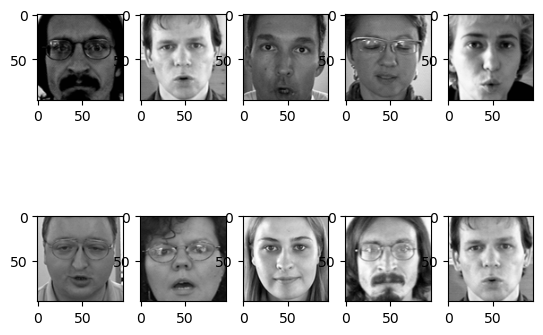

In [7]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(2, 5)
axs = axs.ravel()

for i, ax in zip(range(26*8, 26*8 + 10), axs):
    ex_pict = np.array(data["Image"][i].split(" ")).reshape(96, 96).astype(np.int32)
    print(ex_pict.shape)
    ax.imshow(ex_pict, cmap="gray")

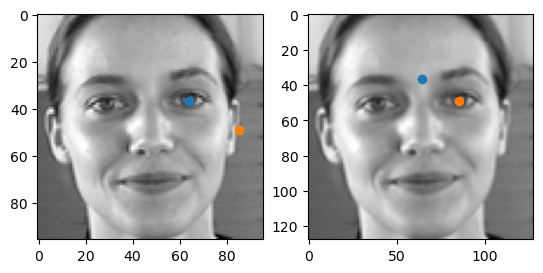

In [8]:
import torch
from torchvision.transforms import Resize

f, axs = plt.subplots(1, 2)
ax1, ax2 = axs.ravel()

ex_pict = np.array(data["Image"][9].split(" ")).reshape(96, 96).astype(np.int32)
left_eye, right_eye = (
    (data["left_eye_center_x"][9],data["left_eye_center_y"][9]),
    (data["right_eye_center_x"][9],data["right_eye_center_y"][9]), 
)
left_eye_r = list(np.array(left_eye) * 1.33)
r = Resize((128,128))
resized_ex_pict = r(torch.Tensor(ex_pict).view(1, 1, 96, 96)).view((128, 128))

for ax, im in [ (ax1, ex_pict), (ax2, resized_ex_pict) ]:
    ax.imshow(
        im,
        cmap="gray"
    )
    ax.plot(*left_eye, marker="o")
    ax.plot(*left_eye_r, marker="o")
    # ax.plot(*right_eye, marker="o")

In [9]:
ex_pict

array([[226, 227, 225, ..., 205, 207, 206],
       [226, 224, 224, ..., 203, 206, 207],
       [225, 226, 224, ..., 204, 207, 207],
       ...,
       [ 86,  90,  91, ..., 117, 116, 115],
       [ 84,  91,  91, ..., 115, 115, 116],
       [ 82,  88,  89, ..., 118, 114, 113]])

In [10]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

processor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-101")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101")

def predict(image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    # convert outputs (bounding boxes and class logits) to COCO API
    # let's only keep detections with score > 0.9
    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        print(
                f"Detected {model.config.id2label[label.item()]} with confidence "
                f"{round(score.item(), 3)} at location {box}"
        )

predict(image)


Detected cat with confidence 0.998 at location [344.06, 24.85, 640.34, 373.74]
Detected remote with confidence 0.997 at location [328.13, 75.93, 372.81, 187.66]
Detected remote with confidence 0.997 at location [39.34, 70.13, 175.56, 118.78]
Detected cat with confidence 0.998 at location [15.36, 51.75, 316.89, 471.16]
Detected couch with confidence 0.995 at location [-0.19, 0.71, 639.73, 474.17]


In [11]:
image = Image.fromarray(np.uint8(ex_pict), "L").convert("RGB")
predict(image)

Detected cell phone with confidence 0.944 at location [2.66, 28.74, 11.25, 59.32]
Detected person with confidence 0.928 at location [-0.03, -0.05, 95.97, 95.95]


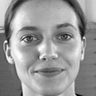

In [12]:
image

In [13]:
from transformers import DetrModel, DetrConfig
config = DetrConfig(num_queries=15)
model2 = DetrModel(config)
model2.from_pretrained("facebook/detr-resnet-101")

Some weights of the model checkpoint at facebook/detr-resnet-101 were not used when initializing DetrModel: ['class_labels_classifier.bias', 'bbox_predictor.layers.2.weight', 'bbox_predictor.layers.0.weight', 'bbox_predictor.layers.1.bias', 'class_labels_classifier.weight', 'bbox_predictor.layers.2.bias', 'bbox_predictor.layers.1.weight', 'bbox_predictor.layers.0.bias']
- This IS expected if you are initializing DetrModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrModel(
  (backbone): DetrConvModel(
    (conv_encoder): DetrTimmConvEncoder(
      (model): FeatureListNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): DetrFrozenBatchNorm2d()
        (act1): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): DetrFrozenBatchNorm2d()
            (drop_block): Identity()
            (act2): ReLU(inplace=True)
            (aa): Identity()
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): DetrFrozenBatchNorm2d()
            (act3): ReLU(inpla

In [14]:
from torch.utils.data import Dataset
from PIL import Image

class FaceDetection(Dataset):
    def __init__(self, df, feature_extractor, *args, train=True, train_ratio=0.8, with_target=True, **kwargs):
        self.df = df
        self.feature_extractor = feature_extractor
        self.train = train
        self.train_ratio = train_ratio
        self.with_target = with_target

    def _get_train_size(self):
        return int(np.ceil(self.df.shape[0] * self.train_ratio))

    def __len__(self):
        train_size = self._get_train_size()
        return train_size if self.train else self.df.shape[0] - train_size

    def __getitem__(self, idx):
        if not self.train:
            idx += self._get_train_size()

        image = Image.fromarray(
            np.array(self.df.loc[idx, "Image"].split(" "), dtype=np.uint8).reshape(96, 96)
        ).convert(
            "RGB"
        ) # TODO: mb you could deal with 1 channel directly by adjusting the config (probably not)
        encoding = self.feature_extractor(image, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        assert pixel_values.shape[-1] == pixel_values.shape[-2]
        if self.with_target:
            target = torch.Tensor(self.df.loc[idx, self.df.columns.drop("Image")])
            ratio_change = pixel_values.shape[1] / image.size[0]
            # print(800/96, ratio_change, pixel_values.shape[1], image.size[0])
            # see the justification
            target *= ratio_change 
            # maxmin normalization
            target /= 800
            return pixel_values, target
        else:
            return pixel_values

In [15]:
train = FaceDetection(data, processor)
val = FaceDetection(data, processor, train=False)

In [16]:
len(train), len(val), data.shape[0]

(5640, 1409, 7049)

In [17]:
test_x, test_y = train[0]
test_x.shape, test_y.shape

(torch.Size([3, 800, 800]), torch.Size([30]))

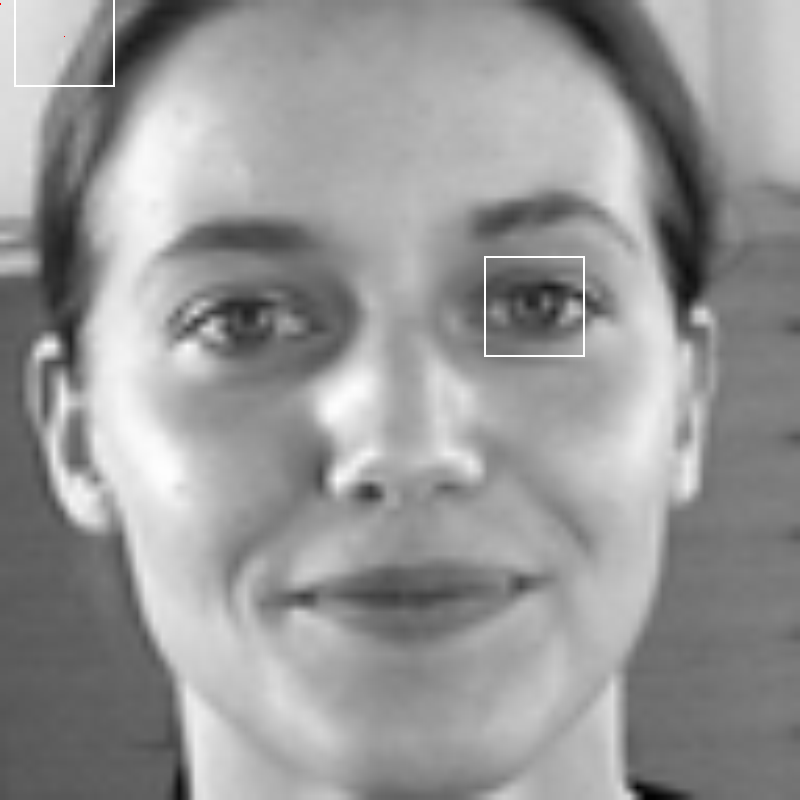

In [18]:
# Justify that the label is set appropriately
from PIL import ImageDraw

def mark(xy, draw):
    x, y = xy
    draw.rectangle((x-50, y-50, x+50, y+50), width=2,)
    draw.point(xy, fill=255)

processor.do_normalize = False
#
preprocessed_img = Image.fromarray(
    processor(Image.fromarray(ex_pict).convert("RGB"), return_tensors="pt", do_normalize=False)["pixel_values"][0].numpy().astype(np.uint8)
)
draw = ImageDraw.Draw(preprocessed_img)
mark(left_eye, draw)
left_eye_resized = np.array(left_eye) * (800/96)
mark(left_eye_resized, draw)
#
processor.do_normalize = True
preprocessed_img

In [19]:
left_eye_resized

array([534.34358974, 306.16923077])

In [20]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  assert np.all(np.array([item.shape for item in pixel_values]) == np.array([(3, 800, 800)]))
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = torch.stack(pixel_values)
#   batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)
  return batch

train_dl = DataLoader(train, batch_size=2, collate_fn=collate_fn)
val_dl = DataLoader(val, batch_size=2, collate_fn=collate_fn)

In [21]:
test_batch = next(iter(train_dl))

In [22]:
test_batch["pixel_values"].shape, test_batch["labels"].shape

(torch.Size([2, 3, 800, 800]), torch.Size([2, 30]))

In [23]:
model2(test_batch["pixel_values"])[0].shape

torch.Size([2, 15, 256])

In [24]:
import torch.nn as nn
import pytorch_lightning as pl
from transformers import DetrModel, DetrConfig, DetrForObjectDetection
import torch.nn.functional as F

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         self.model = DetrModel.from_pretrained("facebook/detr-resnet-101")
         # self.model = DetrForObjectDetection(config)
         # self.model.from_pretrained("facebook/detr-resnet-101")
         # self.model = self.model.model
         # self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101").model
         self.proj = nn.Linear(config.d_model, 2)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)[0][:, :15, :]
       projed = self.proj(outputs)
       return projed
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = batch["labels"]
       batch_size = pixel_values.size(0)
       outputs = self.forward(pixel_values=pixel_values)
       loss = F.mse_loss(outputs.view(batch_size, -1), labels) 
       # metrics ...
       loss_dict = {}

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dl

     def val_dataloader(self):
        return val_dl

In [25]:
# Start tensorboard.
import os
os.environ["TENSORBOARD_BINARY"] = "D:\\miniconda3\\envs\\snow39\\Scripts\\tensorboard.exe"
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 13780), started 3:40:39 ago. (Use '!kill 13780' to kill it.)

In [26]:
processor

DetrFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "DetrFeatureExtractor",
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "max_size": 1333,
  "size": 800
}

In [83]:
import torch.nn as nn
from pytorch_lightning import Trainer

# model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
trainer = Trainer(gpus=1, max_steps=7000, gradient_clip_val=0.1)
trainer.fit(model)

d:\miniconda3\envs\snow39\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | DetrModel | 60.3 M
1 | proj  | Linear    | 514   
------------------------------------
60.1 M    Trainable params
222 K     Non-trainable params
60.3 M    Total params
241.266   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

d:\miniconda3\envs\snow39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
d:\miniconda3\envs\snow39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=7000` reached.


In [84]:
eval_res = trainer.validate(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\miniconda3\envs\snow39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     validation_loss      0.00022528153203893453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [29]:
test = pd.read_csv("./data/test.csv")
test.set_index("ImageId")

,Image
ImageId,
1,182 183 182 182 180 180 176 169 156 137 124 10...
2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
3,177 176 174 170 169 169 168 166 166 166 161 14...
4,176 174 174 175 174 174 176 176 175 171 165 15...
5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
...,...
1779,101 101 101 100 100 97 97 98 102 149 214 206 1...
1780,201 191 171 158 145 140 136 130 123 115 108 10...
1781,28 28 29 30 31 32 33 34 39 44 46 46 49 54 61 7...


In [30]:
test_ds = FaceDetection(test, processor, train_ratio=1, with_target=False)
test_dl = DataLoader(test_ds, batch_size=8)

In [31]:
val_ds_no_target = FaceDetection(data, processor, train=False, with_target=False)
val_dl_no_target = DataLoader(val_ds_no_target, batch_size=8)

In [85]:
pred = trainer.predict(model, test_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\miniconda3\envs\snow39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 1360it [00:00, ?it/s]

In [86]:
pred2 = [item.view(-1, 30) for item in pred]
pred_f = torch.cat(pred2)

In [35]:
len(test)

1783

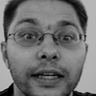

In [41]:
test_pict = Image.fromarray(
    np.asarray(test.iloc[0]["Image"].split(" "), dtype=np.uint8).reshape((96, 96))
)
test_pict

In [36]:
train[0][1]*96

tensor([66.0336, 39.0023, 30.2270, 36.4217, 59.5821, 39.6474, 73.1303, 39.9700,
        36.3566, 37.3894, 23.4529, 37.3894, 56.9533, 29.0336, 80.2271, 32.2281,
        40.2276, 29.0023, 16.3564, 29.6475, 44.4206, 57.0668, 61.1953, 79.9702,
        28.6145, 77.3890, 43.3126, 72.9355, 43.1307, 84.4858])

In [38]:
pred_f[0] * 96

tensor([68.5694, 40.1773, 33.2777, 39.9384, 63.6487, 42.0297, 76.8667, 40.2029,
        39.3885, 41.2194, 25.5207, 38.4737, 61.5825, 29.7693, 84.5332, 31.7977,
        41.2379, 31.6694, 17.2512, 30.8836, 50.6502, 57.9632, 66.6945, 78.3623,
        36.6649, 76.5442, 53.5948, 75.1947, 51.9328, 87.5133])

In [39]:
data.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [87]:
pred_right_eye = list(pred_f[0][2:4].numpy())
pred_right_eye

[0.3166351, 0.3825456]

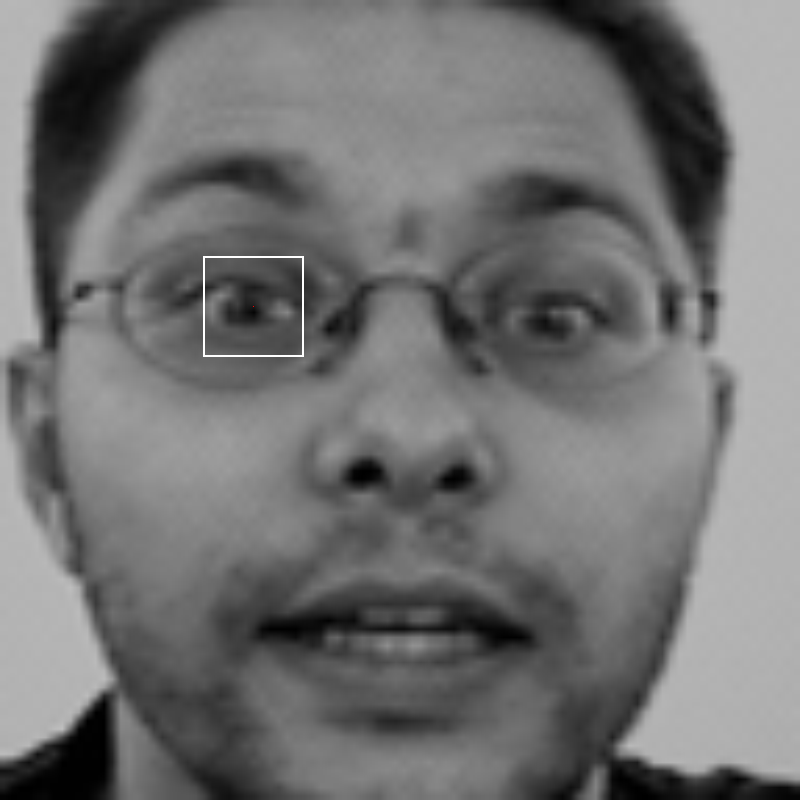

In [92]:
processor.do_normalize = False
preprocessed_img = Image.fromarray(
    processor(test_pict.convert("RGB"), return_tensors="pt", do_normalize=False)["pixel_values"][0].numpy().astype(np.uint8)
)
draw = ImageDraw.Draw(preprocessed_img)
mark(np.array(pred_right_eye) * 800, draw)
processor.do_normalize = True
preprocessed_img

In [53]:
test

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
...,...,...
1778,1779,101 101 101 100 100 97 97 98 102 149 214 206 1...
1779,1780,201 191 171 158 145 140 136 130 123 115 108 10...
1780,1781,28 28 29 30 31 32 33 34 39 44 46 46 49 54 61 7...
1781,1782,104 95 71 57 46 52 65 70 70 67 76 72 69 69 72 ...


In [94]:
pred_df = pd.DataFrame(pred_f.numpy(), columns=data.columns.drop("Image"))
pred_df["ImageId"] = test["ImageId"]
pred_df.set_index("ImageId")


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
ImageId,,,,,,,,,,,,,,,,,,,,,
1,0.690341,0.390548,0.316635,0.382546,0.611925,0.392044,0.761325,0.389715,0.380582,0.391605,...,0.498959,0.607790,0.646518,0.790701,0.339428,0.785975,0.491537,0.752256,0.505040,0.793212
2,0.697311,0.388202,0.300844,0.391222,0.611012,0.392262,0.764069,0.391043,0.377724,0.392997,...,0.495273,0.672613,0.650282,0.790403,0.340965,0.787756,0.491391,0.753449,0.506499,0.821976
3,0.675946,0.389216,0.334926,0.396819,0.609519,0.391331,0.758985,0.390471,0.383198,0.394870,...,0.505221,0.638627,0.647242,0.787718,0.340431,0.785503,0.491242,0.751108,0.518926,0.791098
4,0.686561,0.399830,0.335308,0.415015,0.608978,0.397099,0.761808,0.395763,0.383930,0.398924,...,0.497707,0.622903,0.650601,0.790510,0.337579,0.788503,0.489081,0.754451,0.512224,0.784164
5,0.686402,0.384678,0.299057,0.401131,0.608836,0.394156,0.762757,0.390830,0.378448,0.395360,...,0.493877,0.616078,0.649223,0.789192,0.340323,0.788743,0.491666,0.751634,0.511210,0.792257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,0.693644,0.402502,0.317812,0.379862,0.613948,0.393578,0.760336,0.394243,0.379990,0.391784,...,0.490687,0.678604,0.649226,0.788656,0.338495,0.784326,0.491145,0.750415,0.487678,0.801615
1780,0.680798,0.362965,0.323204,0.417300,0.608492,0.391064,0.760606,0.388818,0.377994,0.394002,...,0.531577,0.635399,0.650321,0.786968,0.339287,0.788174,0.490452,0.751987,0.552723,0.776286
1781,0.697339,0.419628,0.343051,0.383268,0.612572,0.394016,0.760507,0.397070,0.384014,0.393714,...,0.493002,0.686981,0.643650,0.794064,0.336175,0.787588,0.485457,0.754422,0.481028,0.821352


In [56]:
submission_table = pd.read_csv("./data/IdLookupTable.csv")
submission_table.set_index("RowId")

,ImageId,FeatureName,Location
RowId,,,
1,1,left_eye_center_x,NaN
2,1,left_eye_center_y,NaN
3,1,right_eye_center_x,NaN
4,1,right_eye_center_y,NaN
5,1,left_eye_inner_corner_x,NaN
...,...,...,...
27120,1783,right_eye_center_y,NaN
27121,1783,nose_tip_x,NaN
27122,1783,nose_tip_y,NaN


In [71]:
submission_table.loc[0, :]

RowId                          1
ImageId                        1
FeatureName    left_eye_center_x
Location                0.913347
Name: 0, dtype: object

In [95]:
from tqdm import tqdm

for i in tqdm(range(1, submission_table.shape[0] + 1)):
    for_i = submission_table.loc[i, "ImageId"] - 1
    to_pred_i = submission_table.loc[i, "FeatureName"]
    pred_i = pred_df.loc[for_i, to_pred_i]
    submission_table.loc[i, "Location"] = pred_i * 96

100%|██████████| 27124/27124 [00:05<00:00, 4764.43it/s]


In [96]:
# submission_table.set_index("RowId", inplace=True)
submission_table[["Location"]].to_csv("subm3.csv")